## Install requirements

In [ ]:
!pip3 install --quiet "tensorflow>=1.7"

In [3]:
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [45]:
!pip3 install Keras

     |################################| 317kB 938kB/s eta 0:00:01
     |################################| 276kB 20.7MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml


### Import libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import metrics

Using TensorFlow backend.


* Reference


https://tfhub.dev/google/universal-sentence-encoder/1



https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb

### Get Sentence Encoder

In [7]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [8]:
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

In [9]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

## Draw HeatMap

In [94]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    plt.subplots(figsize=(20,15))
    #sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      #xticklabels=labels,
      #yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    #linewidths = 2)
    #g.set_xticklabels(labels, rotation=rotation)

    g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(
        encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(messages_, message_embeddings_, 90)

# Apply Codingbat Data 

In [7]:
data = pd.read_csv("../Total_data.csv")
data = data.drop(columns=['Assignee', 'Quesition_number', 'Category', 'non-important',
       'Recheck', 'Is_done', 'Unnamed: 8',
       'Seperated_sentence'])

In [9]:
# Count the number of labels
data = data.sort_values(by=['loop'])
data.loop.value_counts()

1    168
0    149
Name: loop, dtype: int64

In [101]:
data.head()

,loop,Original_Sentences
228,0,"Given a string, if the string begins with ""red..."
127,0,"Given three ints, a b c, return true if it is ..."
128,0,"Given three ints, a b c, return true if b is g..."
129,0,"Given three ints, a b c, return true if they a..."
130,0,"Given three ints, a b c, return true if two or..."


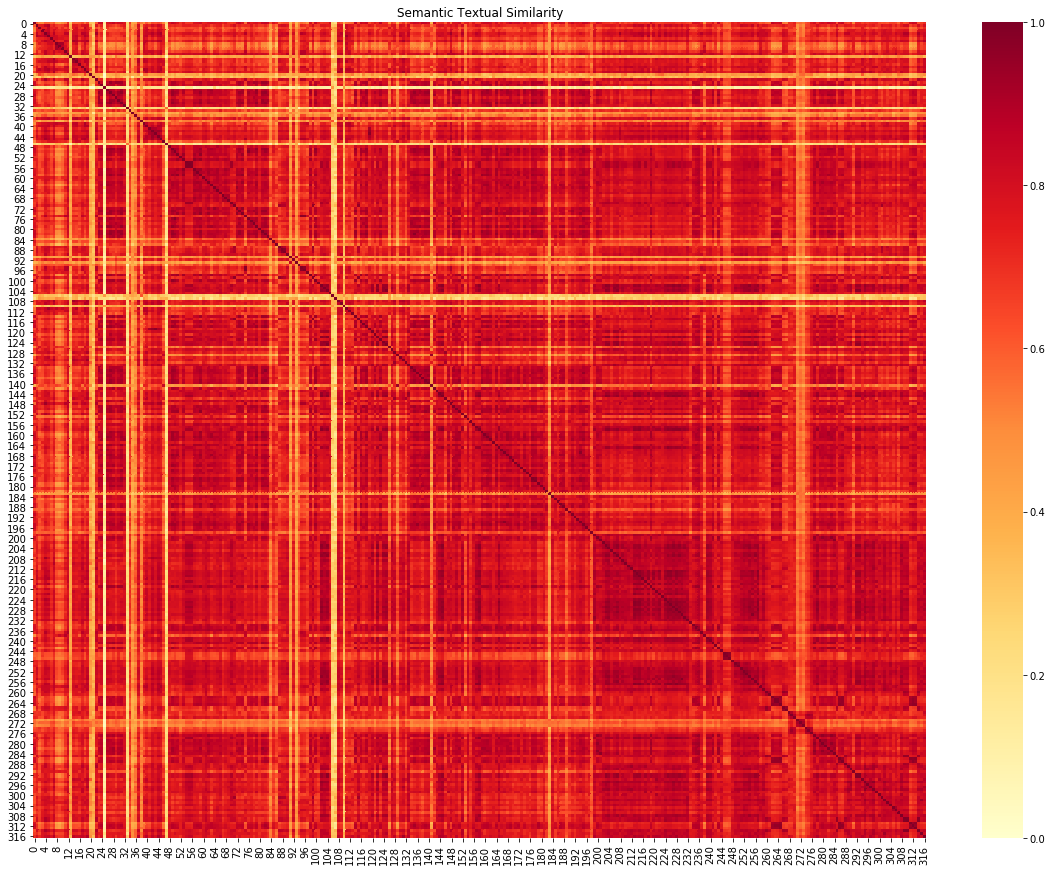

In [98]:
# Briefly look the similarity between sentenses.
sentences = data["Original_Sentences"].values
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, sentences,
               similarity_message_encodings)

### Basic Classification

https://www.tensorflow.org/tutorials/keras/basic_classification

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


In [4]:
# shuffle data and split it as train and test
df = pd.read_csv("Total_data.csv")
print("Length of data : {}" .format(df.shape))
print("Distribution of Loop in Total:")
print(df.loop.value_counts())
print("\n")


train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)
print("Length of train data : {}" .format(train_df.shape))
print("Distribution of Loop in Train:")
print(train_df.loop.value_counts())
print("\n")


print("Length of test data : {}" .format(test_df.shape))
print("Distribution of Loop in Test:")
print(test_df.loop.value_counts())
print("\n")


Length of data : (317, 10)
Distribution of Loop in Total:
1    168
0    149
Name: loop, dtype: int64


Length of train data : (253, 10)
Distribution of Loop in Train:
1    134
0    119
Name: loop, dtype: int64


Length of test data : (64, 10)
Distribution of Loop in Test:
1    34
0    30
Name: loop, dtype: int64




In [5]:
train_df.head()

,Assignee,Quesition_number,Category,loop,non-important,Recheck,Is_done,Original_Sentences,Unnamed: 8,Seperated_sentence
62,JS,63,Array-2,1,NaN,NaN,v,"Given an array of ints, return true if the arr...",NaN,NaN
264,JW,265,String-3,1,2.0,NaN,NaN,"Given a string, return the longest substring t...",NaN,NaN
94,DH,95,Functional-1,1,NaN,NaN,NaN,"Given a list of strings, return a list where e...",NaN,NaN
87,DH,88,Array-3,1,2.0,NaN,NaN,"Given n>=0, create an array length n*n with th...",NaN,NaN
291,JW,292,Warmup-1,0,NaN,NaN,NaN,"Given a string, return a string made of the fi...",NaN,NaN


In [15]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.

train_sentences = train_df["Original_Sentences"].values

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    train_embeddings = session.run(embed(train_sentences))
    print (train_embeddings.shape)
    """
    for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        #print("Embedding: [{}, ...]\n".format(message_embedding_snippet))
        print(format(message_embedding)) #이놈이 출력
        print(type(format(message_embedding_snippet)))
        
    """

(253, 512)


* optimizer</br>


1. class Adadelta: Optimizer that implements the Adadelta algorithm.
2. class Adagrad: Optimizer that implements the Adagrad algorithm.
3. class Adam: Optimizer that implements the Adam algorithm.
4. class Adamax: Optimizer that implements the Adamax algorithm.
5. class Ftrl: Optimizer that implements the FTRL algorithm.
6. class Nadam: Optimizer that implements the NAdam algorithm.
7. class Optimizer: Updated base class for optimizers.
8. class RMSprop: Optimizer that implements the RMSprop algorithm.
9. class SGD: Stochastic gradient descent and momentum optimizer.


* loss function


1. mean_squared_error
2. mean_absolute_error
3. mean_absolute_percentage_error
4. mean_squared_logarithmic_error
5. squared_hinge
6. hinge
7. categorical_hinge
8. logcosh (Logarithm of the hyperbolic cosine of the prediction error.)
9. categorical_crossentropy (Note: targets should be in categorical format)
10. sparse_categorical_crossentropy
11. binary_crossentropy
12. kullback_leibler_divergence
13. poisson
14. cosine_proximity


* metrics

https://github.com/sagr4019/ResearchProject/wiki/Keras-accuracy-(metrics)

 * Accuracy
 
 맞춘 갯수/전체 숫자
 
 This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This frequency is ultimately returned as **binary accuracy**: an idempotent operation that simply divides total by count.

In [13]:
# Basic model to use
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(512,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [56]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [39]:
model.fit(train_embeddings, train_df["loop"].values, epochs=150)

Epoch 1/150
253/253 [==============================] - 1s 6ms/sample - loss: 2.0375 - acc: 0.5138
Epoch 2/150
253/253 [==============================] - 0s 51us/sample - loss: 1.4388 - acc: 0.5850
Epoch 3/150
253/253 [==============================] - 0s 54us/sample - loss: 0.9791 - acc: 0.5968
Epoch 4/150
253/253 [==============================] - 0s 58us/sample - loss: 0.7585 - acc: 0.6759
Epoch 5/150
253/253 [==============================] - 0s 50us/sample - loss: 0.6760 - acc: 0.7115
Epoch 6/150
253/253 [==============================] - 0s 53us/sample - loss: 0.6375 - acc: 0.7273
Epoch 7/150
253/253 [==============================] - 0s 58us/sample - loss: 0.6162 - acc: 0.6996
Epoch 8/150
253/253 [==============================] - 0s 61us/sample - loss: 0.5960 - acc: 0.7470
Epoch 9/150
253/253 [==============================] - 0s 62us/sample - loss: 0.5743 - acc: 0.7510
Epoch 10/150
253/253 [==============================] - 0s 62us/sample - loss: 0.5622 - acc: 0.7431
Epoch 11/1

253/253 [==============================] - 0s 65us/sample - loss: 0.1757 - acc: 0.9605
Epoch 84/150
253/253 [==============================] - 0s 71us/sample - loss: 0.1707 - acc: 0.9605
Epoch 85/150
253/253 [==============================] - 0s 70us/sample - loss: 0.1707 - acc: 0.9644
Epoch 86/150
253/253 [==============================] - 0s 63us/sample - loss: 0.1657 - acc: 0.9605
Epoch 87/150
253/253 [==============================] - 0s 64us/sample - loss: 0.1634 - acc: 0.9684
Epoch 88/150
253/253 [==============================] - 0s 63us/sample - loss: 0.1597 - acc: 0.9684
Epoch 89/150
253/253 [==============================] - 0s 60us/sample - loss: 0.1570 - acc: 0.9684
Epoch 90/150
253/253 [==============================] - 0s 66us/sample - loss: 0.1552 - acc: 0.9684
Epoch 91/150
253/253 [==============================] - 0s 63us/sample - loss: 0.1526 - acc: 0.9684
Epoch 92/150
253/253 [==============================] - 0s 61us/sample - loss: 0.1499 - acc: 0.9644
Epoch 93/150


# Evaluation

In [40]:
test_sentences = test_df["Original_Sentences"].values
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    test_embeddings = session.run(embed(test_sentences))
    print (test_embeddings.shape)
    
    
test_loss, test_acc = model.evaluate(test_embeddings, test_df["loop"].values)

print('Test accuracy:', test_acc)

(64, 512)
64/64 [==============================] - 2s 23ms/sample - loss: 0.4475 - acc: 0.8750
Test accuracy: 0.875


### Record Evaluation


* optimizer = adam, loss=sparse_categorical_crossentropy, metrics=accuracy

accuracy(Binary accuracy) : Calculates the mean accuracy rate across all predictions for binary classification problems.
1. When the number of epochs is 10 -> accuracy : 0.7391 (train_accuracy : 0.8281)
2. When the number of epochs is 50 -> accuracy : 0.8594 (train_accuracy : 0.9091)
3. When the number of epochs is 100 -> test_accuracy : 0.875 (train_accuracy : 0.9644)
4. When the number of epochs is 150 -> test_accuracy : 0.875 (train_accuracy : 0.9960)

참고해보기

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

### Record Evaluation (with 1 dense layer)


* optimizer = adam, loss=sparse_categorical_crossentropy, metrics=accuracy

accuracy(Binary accuracy) : Calculates the mean accuracy rate across all predictions for binary classification problems.
1. When the number of epochs is 10 -> accuracy : 0.7391 (train_accuracy : 0.8281)
2. When the number of epochs is 50 -> accuracy : 0.8594 (train_accuracy : 0.9091)
3. When the number of epochs is 100 -> test_accuracy : 0.875 (train_accuracy : 0.9644)
4. When the number of epochs is 150 -> test_accuracy : 0.875 (train_accuracy : 0.9960)

### Record Evaluation (with 3 dense layers)

* optimizer = adam, loss=sparse_categorical_crossentropy, metrics=accuracy

accuracy(Binary accuracy) : Calculates the mean accuracy rate across all predictions for binary classification problems.

1. When the number of epochs is 10 -> test_accuracy : 0.8438 (train_accuracy : 0.8656)
2. When the number of epochs is 50 -> test_accuracy : 0.9219 (train_accuracy : 1.0000)
3. When the number of epochs is 100 -> test_accuracy : 0.8906 (train_accuracy : 1.0000)




### Record Evaluation (with 2 dense layers)

* optimizer = adam, loss=sparse_categorical_crossentropy, metrics=accuracy

accuracy(Binary accuracy) : Calculates the mean accuracy rate across all predictions for binary classification problems.

1. When the number of epochs is 10 -> test_accuracy : 0.7969 (train_accuracy : 0.8419)
2. When the number of epochs is 50 -> test_accuracy : 0.8906 (train_accuracy : 1.0000)
3. When the number of epochs is 100 -> test_accuracy : 0.9062
(train_accuracy : 1.0000)


In [74]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(512,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])


#################
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.

train_sentences = train_df["Original_Sentences"].values



###############3    
model.fit(train_embeddings, train_df["loop"].values, epochs=100)


test_sentences = test_df["Original_Sentences"].values
# Reduce logging output.

test_loss, test_acc = model.evaluate(test_embeddings, test_df["loop"].values)

print('Test accuracy:', test_acc)

y_predict = model.predict(test_embeddings)

index = 0

correct = [0,0]  # TN, TP
wrong = [0,0]   # FN, FP

for zero_prop, one_prop in y_predict:
    predicted = 0 if zero_prop > one_prop else 1
    true = (test_df["loop"].values)[index]
    if true == predicted :
        correct[true] += 1
    else:
        wrong[predicted] += 1
    index += 1

print('| TN = {0} | FP = {1} | \n| FN = {2} | TP = {3} |'.format(correct[0], wrong[1], wrong[0], correct[1]))

TN = correct[0]; TP = correct[1]; FN = wrong[0]; FP = wrong[1];
precision = TP / (FP + TP)
recall = TP / (FN + TP)
print("precision = ", precision)
print("recall = ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1_score = ", f1_score)

Epoch 1/100
253/253 [==============================] - 8s 32ms/sample - loss: 0.6839 - acc: 0.5217
Epoch 2/100
253/253 [==============================] - 0s 78us/sample - loss: 0.6498 - acc: 0.6403
Epoch 3/100
253/253 [==============================] - 0s 81us/sample - loss: 0.5977 - acc: 0.7312
Epoch 4/100
253/253 [==============================] - 0s 80us/sample - loss: 0.5384 - acc: 0.7747
Epoch 5/100
253/253 [==============================] - 0s 75us/sample - loss: 0.4759 - acc: 0.7945
Epoch 6/100
253/253 [==============================] - 0s 88us/sample - loss: 0.4618 - acc: 0.7905
Epoch 7/100
253/253 [==============================] - 0s 71us/sample - loss: 0.4368 - acc: 0.8024
Epoch 8/100
253/253 [==============================] - 0s 83us/sample - loss: 0.3739 - acc: 0.8458
Epoch 9/100
253/253 [==============================] - 0s 89us/sample - loss: 0.3413 - acc: 0.8419
Epoch 10/100
253/253 [==============================] - 0s 83us/sample - loss: 0.3021 - acc: 0.8735
Epoch 11/

253/253 [==============================] - 0s 83us/sample - loss: 4.1064e-04 - acc: 1.0000
Epoch 83/100
253/253 [==============================] - 0s 94us/sample - loss: 3.9494e-04 - acc: 1.0000
Epoch 84/100
253/253 [==============================] - 0s 84us/sample - loss: 3.7464e-04 - acc: 1.0000
Epoch 85/100
253/253 [==============================] - 0s 83us/sample - loss: 3.5811e-04 - acc: 1.0000
Epoch 86/100
253/253 [==============================] - 0s 91us/sample - loss: 3.4616e-04 - acc: 1.0000
Epoch 87/100
253/253 [==============================] - 0s 86us/sample - loss: 3.3515e-04 - acc: 1.0000
Epoch 88/100
253/253 [==============================] - 0s 97us/sample - loss: 3.1788e-04 - acc: 1.0000
Epoch 89/100
253/253 [==============================] - 0s 88us/sample - loss: 3.1555e-04 - acc: 1.0000
Epoch 90/100
253/253 [==============================] - 0s 95us/sample - loss: 3.1487e-04 - acc: 1.0000
Epoch 91/100
253/253 [==============================] - 0s 95us/sample - loss

In [73]:
print("A")

A
